# Ensemble Learning through Batch Boosting


In [387]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *

## Parameter Configuration

In [388]:
np.random.seed(2020)

In [409]:
N_train = 1000
N_test = 10000
Epsilon  = 1e-3
Max_Iter = 50
Learning_Rate = 0.366
Ratio = 0.4
ratios = [0.25]
d = 1
T = 2

In [390]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [320]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [396]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [397]:
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = s_test.generate_true_V(T)
V_0 = s_test.generate_true_V(0)

V_T_train = s_train.generate_true_V(T)
V_0_train = s_train.generate_true_V(0)

V_0_train = V_0_train.mean()
V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.08026053817102533

In [398]:
from aggregating.utils import flatten_X, normalized_error_VT
#dim(N_test,d*T)
Flattened_X_test = flatten_X(X_test)
# dim(N_train, d*T)
Flattened_X_train = flatten_X(X_train)

In [399]:
#Model with Flatten_X_1
m_1 = GaussianProcessRegressor(kernel)
m_1.fit(Flattened_X_train,y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=39.2) + WhiteKernel(noise_level=2.5))

In [400]:
fX_1 = m_1.predict(Flattened_X_test)

In [401]:
fX_2 = m_1.predict(Flattened_X_train)

In [403]:
test_reference_error = normalized_error_VT(fX_1 ,V_T, V_0)

In [404]:
train_reference_error = normalized_error_VT(fX_2 ,V_T_train, V_0_train)

In [405]:
train_reference_error

0.02276971514195225

In [406]:
test_reference_error 

0.2603028151408908

## Stochastic Gradient Boosting

In [395]:
def Stochastic_Gradient_Boosting(X_train, y_train, X_test, y_test, Max_Iter, min_error, early_stop, kernel, learning_rate, epsilon, sample_size, init):
    np.random.seed(2020)
    error_going_up = 0
    train_prediction = np.zeros(N_train)
    test_prediction = np.zeros(N_test)
    previous_y_hat = np.zeros(N_train)
    previous_y_test_hat = np.zeros(N_test)
    models = []
    train_errors = []
    test_errors = []
    
    y_hat_train = np.full(len(y_train),init)

    y_hat_test = np.full(len(y_test),init)

   
    
    for i in range(Max_Iter):
        model = GaussianProcessRegressor(kernel)
    
        indices = np.random.choice(X_train.shape[0],size=sample_size,replace=False)
       
        model.fit(X_train[indices], y_train[indices] - y_hat_train[indices])
        
        models.append(model)
        
        new_train_predictor = model.predict(X_train)
        new_test_predictor = model.predict(X_test)
        
        y_hat_train += learning_rate * new_train_predictor
        
        y_hat_test += learning_rate * new_test_predictor
                
        #Evaluating TrainSet error
        
        train_errors.append(normalized_error_VT(y_hat_train,y_train,V_0_train).item())
        
        ##Evaluating TestSet error
        
        test_errors.append(normalized_error_VT(y_hat_test,y_test,V_0_test).item())
    
        if (test_errors[-1] < min_error[0]):
            if (( np.abs(min_error[0] - test_errors[-1]) < epsilon)):
                models = models[:min_error[1]+1]
                test_errors = test_errors[:min_error[1]+1]
                
                print("For iteration number {}, the boosting stops as the error isn't decraesing enough anymore with epsilon: {}, test error: {}".format(i, epsilon, min_error[0]))
                logger.info("For iteration number {}, the boosting stops as the error isn't decraesing enough anymore with epsilon: {}, test error: {}".format(i, epsilon, min_error[0]))
                return train_errors, test_errors, min_error
            
            min_error = (test_errors[-1], i)
            error_going_up = 0
            print('For iteration number {}, the test error decreased , test error : {} '.format(i, min_error[0]))
            logger.info("For iteration number {}, the test error decreased , test error : {} ".format(i, min_error[0]))
        else:
            error_going_up += 1
            print('For iteration number {}, the test error increased , test error : {} '.format(i, min_error[0]))
            logger.info("For iteration number {}, the test error increased , test error : {} ".format(i, min_error[0]))
        
            if  (i==(Max_Iter-1)):
                logger.info(f"Max_Iter {Max_Iter} reached")
                models = models[:min_error[1]+1]
                test_errors = test_errors[:min_error[1]+1]
                return train_errors, test_errors, min_error
        
            elif (error_going_up == early_stop ):
                logger.info(f"Early_Stop {early_stop} reached")
                models = models[: -(early_stop)]
                test_errors = test_errors[:-(early_stop)]
                return train_errors, test_errors, min_error
                break #early stopping
                
        
    return train_errors, test_errors, min_error

In [413]:
def Stochastic_Gradient_Boosting_1(X_train, y_train, X_test, y_test, Max_Iter, min_error, early_stop, kernel, learning_rate, epsilon, sample_size, fX_2, fX_1):
    np.random.seed(2020)
    error_going_up = 0
    train_prediction = np.zeros(N_train)
    test_prediction = np.zeros(N_test)
    previous_y_hat = np.zeros(N_train)
    previous_y_test_hat = np.zeros(N_test)
    models = []
    train_errors = []
    test_errors = []
    
    #y_hat_train = np.full(len(y_train),np.mean(y_train, axis=0))
    #y_hat_test = np.full(len(y_test),np.mean(y_train, axis=0))

    y_hat_train = 0.83*fX_2
    y_hat_test = 0.83*fX_1
    
    for i in range(Max_Iter):
        #Evaluating TrainSet error
        
        train_errors.append(normalized_error_VT(y_hat_train,y_train,V_0_train).item())
        
        ##Evaluating TestSet error
        
        test_errors.append(normalized_error_VT(y_hat_test,y_test,V_0).item())
        
        model = GaussianProcessRegressor(kernel)
    
        indices = np.random.choice(X_train.shape[0],size=sample_size,replace=False)
       
        model.fit(X_train[indices], y_train[indices] - y_hat_train[indices])
        models.append(model)
        
        new_train_predictor = model.predict(X_train)
        new_test_predictor = model.predict(X_test)
        
        
        y_hat_train += learning_rate * new_train_predictor
        
        y_hat_test += learning_rate * new_test_predictor
        
    
        if (test_errors[-1] < min_error[0]):
            if (( np.abs(min_error[0] - test_errors[-1]) < epsilon)):
                models = models[:min_error[1]+1]
                test_errors = test_errors[:min_error[1]+1]
                
                print("For iteration number {}, the boosting stops as the error isn't decraesing enough anymore with epsilon: {}, test error: {}".format(i, epsilon, min_error[0]))
                logger.info("For iteration number {}, the boosting stops as the error isn't decraesing enough anymore with epsilon: {}, test error: {}".format(i, epsilon, min_error[0]))
                return train_errors, test_errors, min_error
            
            min_error = (test_errors[-1], i)
            error_going_up = 0
            print('For iteration number {}, the test error decreased , test error : {} '.format(i, min_error[0]))
            logger.info("For iteration number {}, the test error decreased , test error : {} ".format(i, min_error[0]))
        else:
            error_going_up += 1
            print('For iteration number {}, the test error increased , test error : {} '.format(i, min_error[0]))
            logger.info("For iteration number {}, the test error increased , test error : {} ".format(i, min_error[0]))
        
            if  (i==(Max_Iter-1)):
                logger.info(f"Max_Iter {Max_Iter} reached")
                models = models[:min_error[1]+1]
                test_errors = test_errors[:min_error[1]+1]
                return train_errors, test_errors, min_error
        
            elif (error_going_up == early_stop ):
                logger.info(f"Early_Stop {early_stop} reached")
                models = models[: -(early_stop)]
                test_errors = test_errors[:-(early_stop)]
                return train_errors, test_errors, min_error
                break #early stopping
                
         
        
    return train_errors, test_errors, min_error

In [410]:
def Stoch_Grad_Boosting_per_ratio_1(ratios, model, X_train, y_train, X_test, y_test, Epsilon, kernel, Max_Iter,stop,  learning_rate, fX_2, fX_1):
    models = dict((val, []) for val in range(len(ratios))) 
    train_errors = dict((val, []) for val in range(len(ratios))) 
    test_errors = dict((val, []) for val in range(len(ratios))) 
    min_errors = dict((val, []) for val in range(len(ratios))) 

    for i in range(len(ratios)) :
        print(f"Starting evaluation for ratio {ratios[i]}:")
        models[i], train_errors[i], test_errors[i], min_errors[i] = model(X_train, y_train, X_test, y_test, Max_Iter, (float("inf"), float("inf")), stop, kernel, learning_rate, Epsilon, round(X_train.shape[0]*ratios[i]), fX_2, fX_1)
    
    return test_errors


In [393]:
def Stoch_Grad_Boosting_per_ratio(ratios, model, X_train, y_train, X_test, y_test, Epsilon, kernel, Max_Iter,stop,  learning_rate, init):
    models = dict((val, []) for val in range(len(ratios))) 
    train_errors = dict((val, []) for val in range(len(ratios))) 
    test_errors = dict((val, []) for val in range(len(ratios))) 
    min_errors = dict((val, []) for val in range(len(ratios))) 

    for i in range(len(ratios)) :
        print(f"Starting evaluation for ratio {ratios[i]}:")
        models[i], train_errors[i], test_errors[i], min_errors[i] = model(X_train, y_train, X_test, y_test, Max_Iter, (float("inf"), float("inf")), stop, kernel, learning_rate, Epsilon, round(X_train.shape[0]*ratios[i]), init)
    
    return test_errors

In [414]:
test_errors_1 = Stoch_Grad_Boosting_per_ratio_1([1.0], Stochastic_Gradient_Boosting_1, np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Epsilon, kernel, Max_Iter,4,0.7,np.copy(fX_2), np.copy(fX_1))


Starting evaluation for ratio 1.0:
For iteration number 0, the test error decreased , test error : 0.41969815466134963 
For iteration number 1, the test error decreased , test error : 0.26295664946295494 
For iteration number 2, the test error decreased , test error : 0.23640274440171982 
For iteration number 3, the test error decreased , test error : 0.23157132744713776 
For iteration number 4, the test error decreased , test error : 0.23050779714290284 
For iteration number 5, the test error decreased , test error : 0.23017079697356427 
For iteration number 6, the test error decreased , test error : 0.23005294811020005 
For iteration number 7, the test error decreased , test error : 0.23000935377548923 
For iteration number 8, the test error decreased , test error : 0.22999252646181184 
For iteration number 9, the test error decreased , test error : 0.2299857612994716 
For iteration number 10, the test error decreased , test error : 0.22998290523075363 
For iteration number 11, the t

In [407]:
#test_errors_high_dim = Stoch_Grad_Boosting_per_ratio(ratios, Stochastic_Gradient_Boosting, np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Epsilon, kernel, Max_Iter, 0.36, np.mean(y_train, axis=0))
#test_errors_0 = Stoch_Grad_Boosting_per_ratio(ratios, Stochastic_Gradient_Boosting, np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Epsilon, kernel, Max_Iter, 0.7, 0.0)
test_errors_1 = Stoch_Grad_Boosting_per_ratio([0.25], Stochastic_Gradient_Boosting, np.copy(Flattened_X_train), np.copy(y_train), np.copy(Flattened_X_test), np.copy(y_test), Epsilon, kernel, Max_Iter,4,0.7,np.mean(y_train, axis=0))


Starting evaluation for ratio 0.25:
For iteration number 0, the test error decreased , test error : 0.5835936562950536 
For iteration number 1, the test error decreased , test error : 0.22882967848682884 
For iteration number 2, the test error decreased , test error : 0.14604059594845145 
For iteration number 3, the test error decreased , test error : 0.13358351910076371 
For iteration number 4, the test error decreased , test error : 0.13144615536006887 
For iteration number 5, the test error decreased , test error : 0.10782400278364518 
For iteration number 6, the test error increased , test error : 0.10782400278364518
For iteration number 7, the test error increased , test error : 0.10782400278364518
For iteration number 8, the test error increased , test error : 0.10782400278364518


/Users/Clement/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For iteration number 9, the test error increased , test error : 0.10782400278364518


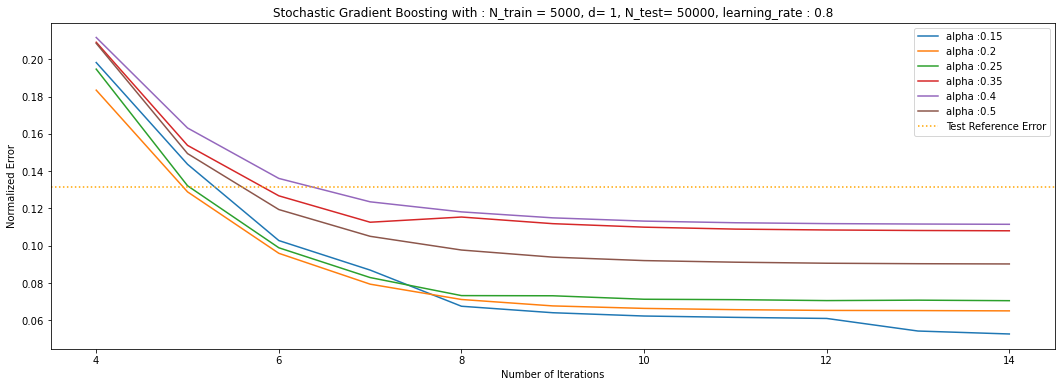

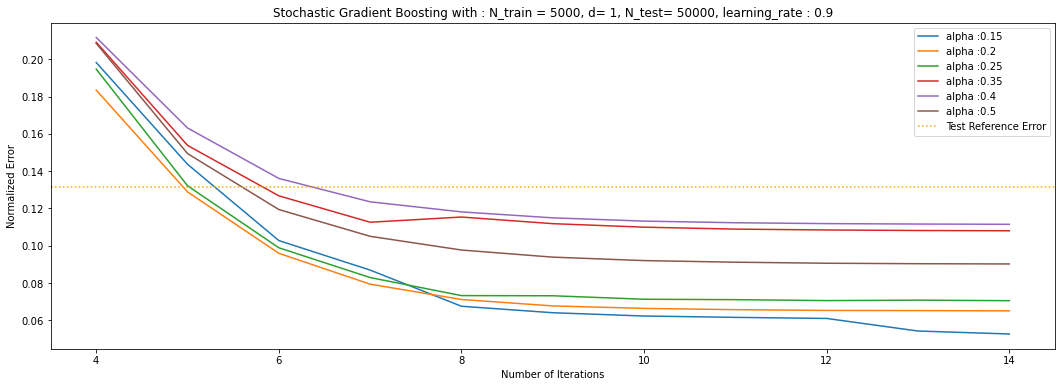

In [55]:
plot_errors(test_errors,ratios, N_train, d, N_test, Learning_Rate, Max_Iter, 0.8)

#plot_errors(test_errors_0,ratios, N_train, d, N_test, Learning_Rate, Max_Iter, '0') 
plot_errors(test_errors_1,ratios, N_train, d, N_test, Learning_Rate, Max_Iter, 0.9) 

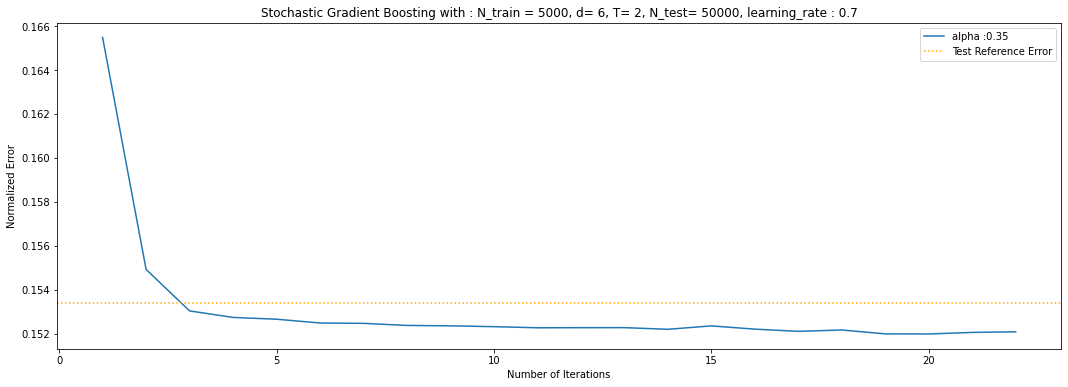

In [386]:
plot_errors(test_errors_1,[0.35], N_train, d, N_test, 0.7, Max_Iter) 

In [44]:

#with open(f"Learning_Rate_{Learning_Rate}.p", "wb") as f:
   # pickle.dump(test_errors,f)

In [453]:
import pickle
PICKLE = True
if PICKLE:
    test_errors_1 = pickle.load(open(f"Learning_Rate_{0.8}.p", "rb"))
    test_errors_2 = pickle.load(open(f"Learning_Rate_{0.9}.p", "rb"))
    #test_errors_1 = pickle.load(open("half_mean_initalisation.p", "rb"))

In [90]:
def log_plot_errors(test_errors, ratios, N_train, d, N_test, Learning_Rate, Max_Iter):
    for i in range(len(test_errors)):
        while len(test_errors[i]) != Max_Iter :
            test_errors[i].append(test_errors[i][-1])
    plt.figure(figsize=((18, 6)))
    for i in range(len(ratios)) :
        #plt.axvline(min_errors[i][1], ls='-', color = 'k', label = 'Test Minimal Error for rate : {rate}')
        plt.plot(np.arange(len(test_errors[i][:61])) , np.log(test_errors[i][:61]), label = f'learning rate :{ratios[i]}')
    plt.axhline(np.log(test_reference_error), ls=':', color = 'orange', label = 'Test Reference Error')
    plt.xlabel("Number of Iterations")
    plt.title(f"Stochastic Gradient Boosting: N_train = {N_train}, d= {d}, N_test= {N_test}, learning_rate : {Learning_Rate}, with different Learning Rates")
    plt.ylabel("Log Normalized Error")
    plt.legend(loc='upper right')
    plt.show()

In [468]:
def plot_errors(test_errors, ratios, N_train, d, N_test, Learning_Rate, Max_Iter):
    
    for i in range(len(test_errors)):
        while len(test_errors[i]) != Max_Iter :
            test_errors[i].append(test_errors[i][-1])
    plt.figure(figsize=((18, 7)))
    for i in range(len(ratios)) :
       
        plt.plot(np.arange(4,23) , test_errors[i][4:23], label = f'alpha :{ratios[i]}')
        
    plt.axhline(0.13, ls=':', color = 'orange', label = 'Test Reference Error')
    plt.xlabel("Number of Iterations")
    plt.title(f"Stochastic Gradient Boosting with : N_train = {N_train}, d= {d}, T= {T}, N_test= {N_test}, learning_rate : {Learning_Rate}")
    plt.ylabel("Normalized Error")
    plt.legend(loc='upper right')
    plt.show()

In [415]:
import json

In [421]:
data_path = '/Users/Clement/ML-Project2/logs/mpi_boosting_low_dim2020-12-16.16-47-39.json'
results = json.load(open(data_path))



In [423]:
len(results)

4

In [435]:
results['test_errors']

[[0.1,
  [1.0590402798175318,
   0.6810348828655522,
   0.4479051608862866,
   0.3009400727505931,
   0.2077199568368006,
   0.15767862766876398,
   0.11965226757936323,
   0.10642574219949182,
   0.0955066751648334,
   0.0875974209534098,
   0.08650707735565395,
   0.08559856174426793,
   0.08518448246167337,
   0.08535737005384363,
   0.0850133932901034,
   0.08488520342640804,
   0.08493942128260677,
   0.08488923443919519,
   0.08485011829420315,
   0.08480539026874188,
   0.07051250957633778,
   0.0705721054977657,
   0.070420082352429,
   0.07050453394744768,
   0.07055264838079837,
   0.0709964476305166,
   0.07095884972067985,
   0.06875728113503835,
   0.06884836055372137,
   0.06731192787115821,
   0.0669850685099855,
   0.06690469675091078,
   0.06667753181259645,
   0.0666899615983439,
   0.06662922139532292],
  [0.06662922139532292, 34]],
 [0.2285714285714286,
  [1.0577186615387555,
   0.6794972586768958,
   0.433002892274897,
   0.28812952291138605,
   0.20231118759050631

In [454]:
test_errors_1[6] = results['test_errors'][0][1]

In [455]:
for i in range(4,8):
    test_errors_1[6+i-3] = results['test_errors'][i][1]

In [450]:
test_errors_1[7]

[1.05927211288013,
 0.6857356782951937,
 0.4526002920917143,
 0.30441534403313847,
 0.21811958163349346,
 0.17189070143595217,
 0.14428127670455318,
 0.13236124442128203,
 0.12829289563944857,
 0.12483100729711939,
 0.12307343962894092,
 0.1221365948893514,
 0.12156759401164452,
 0.12123701340247413,
 0.12114457548605685,
 0.12107719083119896,
 0.121023065455401,
 0.12100441435372586,
 0.12090459876774587,
 0.12083065639299179,
 0.12077095436938413,
 0.12072779789391758,
 0.12072228249160341,
 0.12070353767760827,
 0.12074338528323335,
 0.12064981942011986]

In [456]:
len(test_errors_1)

11

In [ ]:
[0.15, 0.2, 0.25, 0.35, 0.4, 0.5, 0.1, 0.61, 0.74, 0.87, 1.0]  




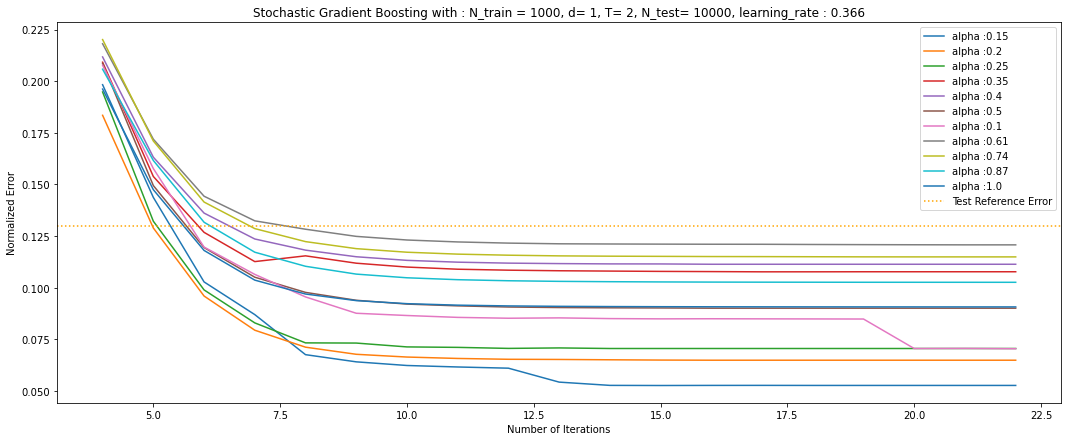

In [469]:
plot_errors(test_errors_1,[0.15, 0.2, 0.25, 0.35, 0.4, 0.5, 0.1, 0.61, 0.74, 0.87, 1.0], N_train, d, N_test, Learning_Rate, Max_Iter) 

In [465]:
results

{'N_train': 5000,
 'N_test': 50000,
 'Ratios': [0.1,
  0.2285714285714286,
  0.3571428571428572,
  0.48571428571428577,
  0.6142857142857143,
  0.7428571428571429,
  0.8714285714285716,
  1.0],
 'test_errors': [[0.1,
   [1.0590402798175318,
    0.6810348828655522,
    0.4479051608862866,
    0.3009400727505931,
    0.2077199568368006,
    0.15767862766876398,
    0.11965226757936323,
    0.10642574219949182,
    0.0955066751648334,
    0.0875974209534098,
    0.08650707735565395,
    0.08559856174426793,
    0.08518448246167337,
    0.08535737005384363,
    0.0850133932901034,
    0.08488520342640804,
    0.08493942128260677,
    0.08488923443919519,
    0.08485011829420315,
    0.08480539026874188,
    0.07051250957633778,
    0.0705721054977657,
    0.070420082352429,
    0.07050453394744768,
    0.07055264838079837,
    0.0709964476305166,
    0.07095884972067985,
    0.06875728113503835,
    0.06884836055372137,
    0.06731192787115821,
    0.0669850685099855,
    0.066904696750910